# Mount drive and bucket
Todo: Remove in public version

In [2]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [3]:
import sys
import datetime
import logging

# nblog = open(f"/content/bigdata/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
# print(nblog)
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

#get_ipython().log.handlers[0].stream = nblog
#get_ipython().log.setLevel(logging.INFO)

%autosave 60

Autosaving every 60 seconds


In [4]:
# if COLAB:
#   from google.colab import drive
#   drive.mount('/content/drive')

In [5]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [6]:
# Todo: Check if possible in local docker
# from google.cloud import storage

In [7]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-03-24 10:01:39.521257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 10:01:39.817176: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 10:01:39.914649: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-24 10:01:40.857682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


In [8]:
from tensorflow import keras
# import tensorflow_gcs_config
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten #, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

In [9]:
import os
from os import listdir
from os.path import isfile, join

In [10]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random

In [11]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [12]:
# Set the checkpoint path for saving train progress
if COLAB:
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [13]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    #%cd /content/CryptoCrystalBall/JupyterDocker/notebooks
    %cd /content

In [14]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [15]:
try:
  from transformers import TFRobertaModel, RobertaConfig
except:
  # Important!: Version 4.23 does not work on TPU
  !pip install transformers==4.22

  from transformers import TFRobertaModel, RobertaConfig

In [16]:
# !pip uninstall -y tensorboard-plugin-profile

In [17]:
# # Required to do profiling
# !pip install tensorboard-plugin-profile

In [18]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [19]:
# # Get the current directory
# current_dir = os.getcwd()
# current_dir_splitted = current_dir.split(os.sep)

# Todo: is inside /content/CB in local docker
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [20]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [21]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [22]:
# Define the tick data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /content/DemoData


In [23]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /content/Documentation/Images


In [24]:
# Define a global random seed
RANDOM_SEED = 42

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [25]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 256

In [26]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 512

In [27]:
# A fixed number of features is used
FEATURES = 160

In [28]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [29]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the train dataset

In [30]:
# Get train file names - Only pick the ones ending with -USDT to prevent
# influence between different currencies
TRAIN_PATH = "/content/dataset/etffancy"

# Get all file names
ALL_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
ALL_FILES = sorted(ALL_FILES)

print(f"The train dataset contains {len(ALL_FILES)} files.")
print(ALL_FILES[:3])

The train dataset contains 1064 files.
['/content/dataset/etffancy/DE0002635265.csv', '/content/dataset/etffancy/DE0002635273.csv', '/content/dataset/etffancy/DE0002635281.csv']


In [31]:
# Split the dataset into train, test (trade algorithm train) and eval (trade algorithm test)
SPLIT_RANDOM_SEED = 666
TRAIN_SET_SIZE = 0.5
TEST_SET_SIZE = 0.25
# EVAL_SET_SIZE: The rest

random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
print(f"train_split_index: {train_split_index}")

test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
print(f"test_split_index: {test_split_index}")

TRAIN_FILES = ALL_FILES[:train_split_index]
TEST_FILES = ALL_FILES[train_split_index:test_split_index]
EVAL_FILES = ALL_FILES[test_split_index:]

train_split_index: 532
test_split_index: 798


---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  
Target values (y-data) from the data generator would not be necessary in this notebook, but since it cannot be switched off, the future direction and its derviation of the price have been chosen in `Y_TYPE_DICT` since they are not expensive to compute. A switch flag will be added in a future release.

In [32]:
# Set past/future gain based trade signals as y target
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN_BASED_TRADE_SIGNALS)
Y_TYPE_DICT

{'dataType': 4,
 'gain_timespan': 60,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48,
 'entryThr1': 0.005,
 'entryThr2': 0.075,
 'exitThr1': 0.05,
 'exitThr2': 0.045}

In [33]:
TARGET_FEATURE_CNT = 256

In [34]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT)
XShape

(512, 256, 256)

In [35]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorSignalsTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y']
        
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [36]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.int32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 3)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

2023-03-24 10:01:45.405963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 10:01:45.514001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 10:01:45.514527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 10:01:45.519721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

<PrefetchDataset element_spec=(TensorSpec(shape=(512, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(512, 3), dtype=tf.int32, name=None))>

---
# Create the neural network

In the example, two Conv1D pyramids are used to extract features at different levels out of the feature and the time dimension.

It is also possible to use different architecures, like LSTM, Conv2D, Attention-Based ones or even NLP-based models. I have already tried many different ones and will publish them into the model zoo.

```
Todo: Create Model Zoo
```

```
Todo: Create Image of netwrok structure
```

In [37]:
# from keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D, UnitNormalization, UpSampling1D
from keras.layers import UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention

In [38]:
# Create the FPNWithFScaledInput model
# Infos about the feature pyramid: https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c

def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttention",
      "VERSION": "6_ETF_Trained_PastFutureGainSignals_TrainSetOnly",
      "CNN_INITIAL_FILTERS": 64, 
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 32,
      "HEAD_DENSE_SIZE": 16
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, TARGET_FEATURE_CNT), name='inputTicksAndIndicators', dtype='float32')

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # Permute it to Conv over Features
  normalized = Permute((2, 1), name="PermuteInput")(normalized)

  # ----------------------------------------------------------------------------

  # As an example a 1D-CNN pyramid is used to extract higher-level features out
  # of the indicator+tick dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"Feature_Conv1D_{i}")(source_layer)

    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(3, activation="softmax", name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 128, 64)
feature_conv_attentioned.shape: (None, 128, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 64, 128)
feature_conv_attentioned.shape: (None, 64, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 32, 256)
feature_conv_attentioned.shape: (None, 32, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 512)
feature_conv_attentioned.shape: (None, 16, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 1024)
feature_conv_attentioned.shape: (None, 8, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 2048)
feature_conv_attentioned.shape: (None, 4, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 4, 256)
Building feat

# Train the model

### Train strategy in the paper
https://huggingface.co/roberta-base

The model was trained on 1024 V100 GPUs for 500K steps with a batch size of 8K and a sequence length of 512. The optimizer used is Adam with a learning rate of 6e-4, β1=0.9\beta_{1} = 0.9β1​=0.9, β2=0.98\beta_{2} = 0.98β2​=0.98 and ϵ=1e−6\epsilon = 1e-6ϵ=1e−6, a weight decay of 0.01, learning rate warmup for 24,000 steps and linear decay of the learning rate after.

In [39]:
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttention_6_ETF_Trained_PastFutureGainSignals_TrainSetOnly_GPU_256LB'

In [40]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-03,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [41]:
model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=None)

In [42]:
#@title CustomCallback
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

      fp = os.path.join(_save_folder, "c.pickle")
      with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
      logging.info(f"Saved optimizer config to '{fp}'")

      # Save optimizer weights
      # w = copy.deepcopy(self.model.optimizer.get_weights())

      fp = os.path.join(_save_folder, "w.pickle")
      with open(fp, "wb") as handle:
        # with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
      logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [43]:
gc.collect()

9821

In [44]:
# CLASS_WEIGHTS_DICT = None

# Based on counts of {0: 2800.0, 1: 251700.0, 2: 277400.0}
# CLASS_WEIGHTS_DICT = {0: 99.07142857142857, 1: 1.1021056813667065, 2: 1.0}
CLASS_WEIGHTS_DICT = {0: 3.0, 1: 1.1021056813667065, 2: 1.0} #Kind of log

In [45]:
epoch_add = 22

In [46]:
CALLBACK_EVERY_N_BATCHES = 2000

In [47]:
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [48]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [49]:
%reload_ext tensorboard

The TensorBoard UI is displayed in a browser window. In this colab, perform the following steps to prepare to capture profile information.
1.  Click on the dropdown menu box on the top right side and scroll down and click PROFILE. A new window appears that shows: **No profile data was found** at the top.
1.  Click on the CAPTURE PROFILE button. A new dialog appears. The top input line shows: **Profile Service URL or TPU name**. Copy and paste the Profile Service URL (the service_addr value shown before launching TensorBoard) into the top input line. While still on the dialog box, start the training with the next step.
1.  Click on the next colab cell to start training the model.
1.  Watch the output from the training until several epochs have completed. This allows time for the profile data to start being collected. Return to the dialog box and click on the CAPTURE button. If the capture succeeds, the page will auto refresh and redirect you to the profiling results.

In [50]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/bigdata/log",log_dir.split("/")[-1])

log_dir

'/content/bigdata/log/FPNWithAttention_6_ETF_Trained_PastFutureGainSignals_TrainSetOnly_GPU_256LB20230324-100147'

In [51]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-03-24 10:01:47.499730: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-24 10:01:47.499753: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-24 10:01:47.500481: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-03-24 10:01:47.500713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-03-24 10:01:47.629835: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-24 10:01:47.630016: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [52]:
# model.load_weights("/content/bigdata/chk/FPNWithAttention_6_ETF_Trained_PastFutureGainSignals_TrainSetOnly_GPU_256LB/cp_daily_valid_21_end/model.h5")

In [53]:
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

In [54]:
model.fit(tfGenTraining,
          epochs=1,
          verbose = 1,
          callbacks=[tensorboard_callback, cc],
          class_weight=CLASS_WEIGHTS_DICT)

INFO:root:File 'IE00B6X2VY59.csv' loaded, 531 left
INFO:root:File 'IE00BYXVGZ48.csv' loaded, 530 left
INFO:root:File 'DE000A0F5UF5.csv' loaded, 529 left
INFO:root:File 'DE000ETFL441.csv' loaded, 528 left
INFO:root:File 'LU1781541179.csv' loaded, 527 left
INFO:root:File 'LU1650487926.csv' loaded, 526 left
INFO:root:File 'LU1285960032.csv' loaded, 525 left
INFO:root:File 'IE00B1FZSD53.csv' loaded, 524 left
2023-03-24 10:02:04.775677: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-03-24 10:02:06.053782: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
INFO:root:File 'IE00B5KQNG97.csv' loaded, 523 left


      1/Unknown - 25s 25s/step - loss: 1.2613

INFO:root:File 'IE00BYM31M36.csv' loaded, 522 left


      4/Unknown - 26s 404ms/step - loss: 1.0617

2023-03-24 10:02:16.250250: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-24 10:02:16.250278: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


      6/Unknown - 27s 399ms/step - loss: 1.0636WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1040s vs `on_train_batch_end` time: 0.1449s). Check your callbacks.


     12/Unknown - 28s 271ms/step - loss: 1.0274

INFO:root:File 'LU2082996542.csv' loaded, 521 left


     27/Unknown - 30s 220ms/step - loss: 1.0342

INFO:root:File 'IE00BF4G7076.csv' loaded, 520 left


     39/Unknown - 33s 225ms/step - loss: 1.0346

INFO:root:File 'IE00BQN1K786.csv' loaded, 519 left


     45/Unknown - 37s 274ms/step - loss: 1.0433

INFO:root:File 'LU0136240974.csv' loaded, 518 left


     54/Unknown - 43s 339ms/step - loss: 1.0330

INFO:root:File 'IE00BLDGH447.csv' loaded, 517 left


     55/Unknown - 43s 345ms/step - loss: 1.0329

INFO:root:File 'IE00BFTWP510.csv' loaded, 516 left


     57/Unknown - 46s 373ms/step - loss: 1.0383

INFO:root:File 'IE00BQT3WG13.csv' loaded, 515 left


     63/Unknown - 49s 392ms/step - loss: 1.0294

INFO:root:File 'LU1407888053.csv' loaded, 514 left


     77/Unknown - 55s 405ms/step - loss: 1.0343

INFO:root:File 'IE00BMYDM794.csv' loaded, 513 left


     82/Unknown - 58s 411ms/step - loss: 1.0356

INFO:root:File 'IE00B441G979.csv' loaded, 512 left


     85/Unknown - 61s 429ms/step - loss: 1.0366

INFO:root:File 'IE00B8X9NY41.csv' loaded, 511 left


     88/Unknown - 63s 441ms/step - loss: 1.0359

INFO:root:File 'IE00BMDH1538.csv' loaded, 510 left


     91/Unknown - 65s 446ms/step - loss: 1.0338

INFO:root:File 'IE00BLF7VX27.csv' loaded, 509 left


     95/Unknown - 67s 451ms/step - loss: 1.0312

INFO:root:File 'IE00BYMS5W68.csv' loaded, 508 left


     98/Unknown - 69s 459ms/step - loss: 1.0279

INFO:root:File 'LU1079842321.csv' loaded, 507 left


     99/Unknown - 70s 464ms/step - loss: 1.0278

INFO:root:File 'IE00BKVL7778.csv' loaded, 506 left
2023-03-24 10:03:02.068945: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-24 10:03:02.071580: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-03-24 10:03:02.348098: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 463297 callback api events and 465473 activity events. 
INFO:root:File 'LU1681045537.csv' loaded, 505 left
INFO:root:File 'IE00B60SX287.csv' loaded, 504 left
2023-03-24 10:03:06.188501: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
INFO:root:File 'IE00BJXRT698.csv' loaded, 503 left
2023-03-24 10:03:09.999228: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /content/bigdata/log/FPNWithAttention_6_ETF_Trained_PastFutureGainSignals_TrainSetOnly_GPU_256LB20230324-100147/plugins/profile/2023_03_24_10_03_06

2023-03-24 10:03:1

    107/Unknown - 88s 596ms/step - loss: 1.0228

INFO:root:File 'IE00BYTH5T38.csv' loaded, 501 left


    114/Unknown - 89s 571ms/step - loss: 1.0216

INFO:root:File 'IE00077FRP95.csv' loaded, 500 left


    121/Unknown - 90s 548ms/step - loss: 1.0194

INFO:root:File 'DE0002635273.csv' loaded, 499 left


    129/Unknown - 93s 537ms/step - loss: 1.0183

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 498 left


    140/Unknown - 98s 525ms/step - loss: 1.0207

INFO:root:File 'IE00BKVL7D31.csv' loaded, 497 left


    149/Unknown - 102s 522ms/step - loss: 1.0200

INFO:root:File 'LU2356220926.csv' loaded, 496 left


    153/Unknown - 104s 521ms/step - loss: 1.0219

INFO:root:File 'IE00BYZK4883.csv' loaded, 495 left


    154/Unknown - 104s 521ms/step - loss: 1.0207

INFO:root:File 'IE00B4YBJ215.csv' loaded, 494 left


    155/Unknown - 106s 526ms/step - loss: 1.0194

INFO:root:File 'IE00BMDKNW35.csv' loaded, 493 left


    161/Unknown - 110s 534ms/step - loss: 1.0201

INFO:root:File 'LU1769088581.csv' loaded, 492 left


    163/Unknown - 112s 537ms/step - loss: 1.0187

INFO:root:File 'IE00B6YX5B26.csv' loaded, 491 left


    175/Unknown - 118s 535ms/step - loss: 1.0248

INFO:root:File 'LU2023678449.csv' loaded, 490 left


    178/Unknown - 120s 537ms/step - loss: 1.0239

INFO:root:File 'LU1953188833.csv' loaded, 489 left


    185/Unknown - 123s 535ms/step - loss: 1.0250

INFO:root:File 'LU1861134382.csv' loaded, 488 left


    186/Unknown - 124s 535ms/step - loss: 1.0253

INFO:root:File 'IE00BLRPN388.csv' loaded, 487 left


    187/Unknown - 125s 541ms/step - loss: 1.0248

INFO:root:File 'LU1781540957.csv' loaded, 486 left


    194/Unknown - 129s 540ms/step - loss: 1.0221

INFO:root:File 'IE00BD9MMF62.csv' loaded, 485 left


    195/Unknown - 130s 543ms/step - loss: 1.0214

INFO:root:File 'LU1806495575.csv' loaded, 484 left


    200/Unknown - 133s 544ms/step - loss: 1.0202

INFO:root:File 'DE000A0H08N1.csv' loaded, 483 left


    207/Unknown - 138s 550ms/step - loss: 1.0233

INFO:root:File 'LU2082997946.csv' loaded, 482 left


    212/Unknown - 141s 549ms/step - loss: 1.0224

INFO:root:File 'DE0002635307.csv' loaded, 481 left


    213/Unknown - 141s 549ms/step - loss: 1.0216

INFO:root:File 'IE00BWBXM492.csv' loaded, 480 left


    217/Unknown - 146s 561ms/step - loss: 1.0196

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 479 left
INFO:root:File 'LU0832436512.csv' loaded, 478 left


    218/Unknown - 148s 566ms/step - loss: 1.0184

INFO:root:File 'IE00BD3V0B10.csv' loaded, 477 left


    224/Unknown - 152s 571ms/step - loss: 1.0193

INFO:root:File 'IE00BYTRR863.csv' loaded, 476 left


    229/Unknown - 155s 572ms/step - loss: 1.0190

INFO:root:File 'DE000ETFL037.csv' loaded, 475 left


    241/Unknown - 162s 570ms/step - loss: 1.0211

INFO:root:File 'IE00B60SX170.csv' loaded, 474 left


    253/Unknown - 168s 568ms/step - loss: 1.0246

INFO:root:File 'LU1215454460.csv' loaded, 473 left


    259/Unknown - 171s 568ms/step - loss: 1.0271

INFO:root:File 'IE00BJXRZ273.csv' loaded, 472 left


    267/Unknown - 175s 566ms/step - loss: 1.0276

INFO:root:File 'IE00BKT1CS59.csv' loaded, 471 left


    272/Unknown - 178s 565ms/step - loss: 1.0290

INFO:root:File 'LU1287023342.csv' loaded, 470 left


    273/Unknown - 178s 564ms/step - loss: 1.0298

INFO:root:File 'LU1981859819.csv' loaded, 469 left


    280/Unknown - 183s 569ms/step - loss: 1.0265

INFO:root:File 'LU1841731745.csv' loaded, 468 left


    288/Unknown - 187s 566ms/step - loss: 1.0243

INFO:root:File 'IE000L5NW549.csv' loaded in retry loop, 467 left


    291/Unknown - 189s 566ms/step - loss: 1.0255

INFO:root:File 'IE00B4LN9N13.csv' loaded, 466 left


    292/Unknown - 189s 565ms/step - loss: 1.0251

INFO:root:File 'FR0010869578.csv' loaded, 465 left


    301/Unknown - 195s 569ms/step - loss: 1.0261

INFO:root:File 'IE00BCRY6557.csv' loaded, 464 left


    310/Unknown - 200s 568ms/step - loss: 1.0276

INFO:root:File 'LU2090062949.csv' loaded, 463 left


    314/Unknown - 202s 567ms/step - loss: 1.0278

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 462 left


    317/Unknown - 205s 570ms/step - loss: 1.0270

INFO:root:File 'IE00B1TXHL60.csv' loaded, 461 left
INFO:root:File 'IE00BMQ8YK98.csv' loaded, 460 left


    320/Unknown - 209s 576ms/step - loss: 1.0261

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 459 left


    321/Unknown - 209s 576ms/step - loss: 1.0261

INFO:root:File 'LU1525418643.csv' loaded, 458 left
INFO:root:File 'IE00BJK9H753.csv' loaded, 457 left


    339/Unknown - 219s 575ms/step - loss: 1.0210

INFO:root:File 'LU2082997359.csv' loaded, 456 left


    347/Unknown - 223s 572ms/step - loss: 1.0192

INFO:root:File 'IE00B6YX5L24.csv' loaded, 455 left


    349/Unknown - 225s 575ms/step - loss: 1.0180

INFO:root:File 'LU2082996898.csv' loaded, 454 left


    351/Unknown - 226s 576ms/step - loss: 1.0172

INFO:root:File 'IE00B3B8PX14.csv' loaded, 453 left
INFO:root:File 'IE00B02KXL92.csv' loaded, 452 left


    359/Unknown - 233s 583ms/step - loss: 1.0205

INFO:root:File 'LU1681041205.csv' loaded, 451 left


    361/Unknown - 236s 586ms/step - loss: 1.0215

INFO:root:File 'IE00BHZPJ015.csv' loaded, 450 left


    363/Unknown - 237s 587ms/step - loss: 1.0206

INFO:root:File 'LU0959210278.csv' loaded, 449 left


    373/Unknown - 242s 585ms/step - loss: 1.0181

INFO:root:File 'IE000KPJJWM6.csv' loaded, 448 left


    374/Unknown - 243s 585ms/step - loss: 1.0180

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 447 left


    379/Unknown - 246s 586ms/step - loss: 1.0169

INFO:root:File 'IE000NDWFGA5.csv' loaded, 446 left


    380/Unknown - 247s 586ms/step - loss: 1.0174

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 445 left


    404/Unknown - 257s 577ms/step - loss: 1.0155

INFO:root:File 'IE00BGJWWY63.csv' loaded, 444 left


    405/Unknown - 258s 579ms/step - loss: 1.0154

INFO:root:File 'IE00BJK9HD13.csv' loaded, 443 left


    414/Unknown - 263s 576ms/step - loss: 1.0126

INFO:root:File 'IE00BMH5Y871.csv' loaded, 442 left


    416/Unknown - 264s 576ms/step - loss: 1.0118

INFO:root:File 'IE00BYV1Y969.csv' loaded, 441 left


    417/Unknown - 264s 576ms/step - loss: 1.0119

INFO:root:File 'LU0392496427.csv' loaded, 440 left
INFO:root:File 'IE00BNDS1P30.csv' loaded, 439 left


    420/Unknown - 269s 582ms/step - loss: 1.0111

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 438 left


    422/Unknown - 271s 585ms/step - loss: 1.0111

INFO:root:File 'DE000A0H08H3.csv' loaded, 437 left


    423/Unknown - 272s 585ms/step - loss: 1.0115

INFO:root:File 'IE00BHXMHL11.csv' loaded, 436 left


    424/Unknown - 274s 590ms/step - loss: 1.0109

INFO:root:File 'IE00BYTRRC02.csv' loaded, 435 left


    430/Unknown - 278s 591ms/step - loss: 1.0117

INFO:root:File 'DE000ETF7011.csv' loaded, 434 left


    441/Unknown - 284s 589ms/step - loss: 1.0135

INFO:root:File 'IE00BYPLS672.csv' loaded, 433 left


    442/Unknown - 284s 588ms/step - loss: 1.0131

INFO:root:File 'IE00B2NPL135.csv' loaded, 432 left


    452/Unknown - 291s 591ms/step - loss: 1.0150

INFO:root:File 'DE000ETFL565.csv' loaded, 431 left


    459/Unknown - 294s 589ms/step - loss: 1.0154

INFO:root:File 'IE00BYSX4846.csv' loaded, 430 left


    463/Unknown - 297s 589ms/step - loss: 1.0173

INFO:root:File 'IE0032895942.csv' loaded, 429 left


    465/Unknown - 300s 593ms/step - loss: 1.0172

INFO:root:File 'LU1230561679.csv' loaded, 428 left


    479/Unknown - 306s 590ms/step - loss: 1.0176

INFO:root:File 'IE00BZ048462.csv' loaded, 427 left


    486/Unknown - 310s 589ms/step - loss: 1.0184

INFO:root:File 'LU1829218822.csv' loaded, 426 left


    493/Unknown - 315s 589ms/step - loss: 1.0189

INFO:root:File 'LU2182388400.csv' loaded, 425 left


    498/Unknown - 317s 588ms/step - loss: 1.0182

INFO:root:File 'IE00BM8R0N95.csv' loaded, 424 left


    501/Unknown - 319s 588ms/step - loss: 1.0177

INFO:root:File 'IE00BK5BR626.csv' loaded, 423 left


    503/Unknown - 320s 589ms/step - loss: 1.0173

INFO:root:File 'IE00B4L5YC18.csv' loaded, 422 left


    504/Unknown - 321s 588ms/step - loss: 1.0169

INFO:root:File 'LU2197908721.csv' loaded, 421 left


    507/Unknown - 324s 591ms/step - loss: 1.0177

INFO:root:File 'IE00B1FZS798.csv' loaded, 420 left


    514/Unknown - 329s 593ms/step - loss: 1.0173

INFO:root:File 'IE00BYV1YH46.csv' loaded, 419 left


    517/Unknown - 331s 593ms/step - loss: 1.0173

INFO:root:File 'IE00B3YLTY66.csv' loaded, 418 left


    524/Unknown - 335s 593ms/step - loss: 1.0158

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 417 left


    535/Unknown - 340s 590ms/step - loss: 1.0160

INFO:root:File 'IE000EBFYWX3.csv' loaded, 416 left


    536/Unknown - 340s 590ms/step - loss: 1.0160

INFO:root:File 'LU1829219390.csv' loaded, 415 left


    537/Unknown - 341s 590ms/step - loss: 1.0160

INFO:root:File 'DE0005933931.csv' loaded, 414 left


    540/Unknown - 346s 596ms/step - loss: 1.0157

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 413 left


    558/Unknown - 354s 591ms/step - loss: 1.0149

INFO:root:File 'DE0006289499.csv' loaded, 412 left


    561/Unknown - 357s 594ms/step - loss: 1.0152

INFO:root:File 'LU1812090543.csv' loaded, 411 left


    572/Unknown - 363s 593ms/step - loss: 1.0174

INFO:root:File 'DE0006289390.csv' loaded, 410 left


    576/Unknown - 367s 596ms/step - loss: 1.0171

INFO:root:File 'IE00BM9GRM34.csv' loaded, 409 left


    580/Unknown - 369s 595ms/step - loss: 1.0180

INFO:root:File 'DE0002635299.csv' loaded, 408 left


    583/Unknown - 372s 598ms/step - loss: 1.0179

INFO:root:File 'LU1377382368.csv' loaded, 407 left


    585/Unknown - 374s 598ms/step - loss: 1.0180

INFO:root:File 'LU1437015735.csv' loaded, 406 left


    596/Unknown - 380s 596ms/step - loss: 1.0165

INFO:root:File 'IE00B7452L46.csv' loaded, 405 left


    611/Unknown - 387s 594ms/step - loss: 1.0144

INFO:root:File 'IE00BYTRRB94.csv' loaded, 404 left


    617/Unknown - 391s 594ms/step - loss: 1.0141

INFO:root:File 'IE00BHZRQY00.csv' loaded, 403 left


    626/Unknown - 395s 592ms/step - loss: 1.0146

INFO:root:File 'LU1437018168.csv' loaded, 402 left


    634/Unknown - 399s 591ms/step - loss: 1.0148

INFO:root:File 'LU1291098827.csv' loaded, 401 left


    646/Unknown - 405s 589ms/step - loss: 1.0147

INFO:root:File 'LU1681042609.csv' loaded, 400 left


    655/Unknown - 410s 589ms/step - loss: 1.0132

INFO:root:File 'LU1681047319.csv' loaded, 399 left


    658/Unknown - 413s 591ms/step - loss: 1.0125

INFO:root:File 'LU1681044480.csv' loaded, 398 left


    659/Unknown - 415s 593ms/step - loss: 1.0128

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 397 left


    666/Unknown - 419s 593ms/step - loss: 1.0140

INFO:root:File 'DE000A0Q4R36.csv' loaded, 396 left


    670/Unknown - 423s 595ms/step - loss: 1.0142

INFO:root:File 'LU1900066975.csv' loaded, 395 left


    678/Unknown - 428s 596ms/step - loss: 1.0137

INFO:root:File 'LU2109786827.csv' loaded, 394 left


    690/Unknown - 434s 594ms/step - loss: 1.0140

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left
INFO:root:File 'IE00BZ4BMM98.csv' loaded, 392 left


    703/Unknown - 442s 594ms/step - loss: 1.0148

INFO:root:File 'FR0011475078.csv' loaded, 391 left


    722/Unknown - 450s 590ms/step - loss: 1.0151

INFO:root:File 'IE00B5MTYK77.csv' loaded, 390 left


    723/Unknown - 452s 592ms/step - loss: 1.0148

INFO:root:File 'LU0629460089.csv' loaded, 389 left


    725/Unknown - 454s 594ms/step - loss: 1.0147

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


    727/Unknown - 456s 594ms/step - loss: 1.0159

INFO:root:File 'IE00BWTNM966.csv' loaded, 387 left


    743/Unknown - 463s 591ms/step - loss: 1.0167

INFO:root:File 'IE00B52SF786.csv' loaded, 386 left


    755/Unknown - 470s 590ms/step - loss: 1.0166

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 385 left


    760/Unknown - 473s 590ms/step - loss: 1.0163

INFO:root:File 'LU1650491795.csv' loaded, 384 left


    762/Unknown - 474s 590ms/step - loss: 1.0161

INFO:root:File 'IE00BHJYDV33.csv' loaded, 383 left
INFO:root:File 'IE00BYZK4669.csv' loaded, 382 left


    770/Unknown - 479s 590ms/step - loss: 1.0166

INFO:root:File 'IE00B1FZS350.csv' loaded, 381 left


    781/Unknown - 485s 590ms/step - loss: 1.0181

INFO:root:File 'IE00BLRPRR04.csv' loaded, 380 left


    785/Unknown - 487s 590ms/step - loss: 1.0185

INFO:root:File 'LU0603940916.csv' loaded, 379 left


    787/Unknown - 489s 591ms/step - loss: 1.0187

INFO:root:File 'IE00B979GK47.csv' loaded, 378 left
INFO:root:File 'IE00BYPC1H27.csv' loaded, 377 left


    795/Unknown - 494s 591ms/step - loss: 1.0188

INFO:root:File 'DE000ETFL482.csv' loaded, 376 left


    796/Unknown - 494s 591ms/step - loss: 1.0188

INFO:root:File 'LU2056739464.csv' loaded, 375 left


    798/Unknown - 497s 592ms/step - loss: 1.0185

INFO:root:File 'IE000ST40PX8.csv' loaded, 374 left


    799/Unknown - 497s 592ms/step - loss: 1.0185

INFO:root:File 'IE00BQN1K901.csv' loaded, 373 left


    803/Unknown - 500s 593ms/step - loss: 1.0186

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 372 left


    804/Unknown - 501s 593ms/step - loss: 1.0189

INFO:root:File 'IE00BJQRDM08.csv' loaded, 371 left


    808/Unknown - 504s 594ms/step - loss: 1.0187

INFO:root:File 'IE00B8FHGS14.csv' loaded, 370 left


    814/Unknown - 508s 594ms/step - loss: 1.0189

INFO:root:File 'IE00B1FZS913.csv' loaded, 369 left


    821/Unknown - 512s 595ms/step - loss: 1.0185

INFO:root:File 'LU2198883410.csv' loaded, 368 left


    832/Unknown - 517s 593ms/step - loss: 1.0186

INFO:root:File 'IE00B5MTZM66.csv' loaded, 367 left


    834/Unknown - 520s 594ms/step - loss: 1.0186

INFO:root:File 'IE00B1W57M07.csv' loaded, 366 left


    840/Unknown - 524s 595ms/step - loss: 1.0185

INFO:root:File 'IE00BMDBMT65.csv' loaded, 365 left


    847/Unknown - 527s 594ms/step - loss: 1.0191

INFO:root:File 'LU1681039134.csv' loaded, 364 left


    848/Unknown - 528s 594ms/step - loss: 1.0189

INFO:root:File 'LU1681041544.csv' loaded, 363 left


    849/Unknown - 529s 595ms/step - loss: 1.0188

INFO:root:File 'IE00B8GF1M35.csv' loaded, 362 left


    859/Unknown - 536s 596ms/step - loss: 1.0191

INFO:root:File 'FR0010361683.csv' loaded, 361 left


    862/Unknown - 540s 599ms/step - loss: 1.0189

INFO:root:File 'IE00BDDRF478.csv' loaded, 360 left


    884/Unknown - 550s 594ms/step - loss: 1.0206

INFO:root:File 'IE00BGBN6P67.csv' loaded, 359 left


    887/Unknown - 551s 595ms/step - loss: 1.0204

INFO:root:File 'LU1650488494.csv' loaded, 358 left


    902/Unknown - 560s 594ms/step - loss: 1.0215

INFO:root:File 'LU1681045024.csv' loaded, 357 left
INFO:root:File 'IE00BYXVGY31.csv' loaded, 356 left


    903/Unknown - 561s 595ms/step - loss: 1.0215

INFO:root:File 'IE00BFNM3B99.csv' loaded, 355 left


    906/Unknown - 564s 596ms/step - loss: 1.0218

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 354 left


    920/Unknown - 571s 594ms/step - loss: 1.0215

INFO:root:File 'IE0032077012.csv' loaded, 353 left


    923/Unknown - 574s 596ms/step - loss: 1.0215

INFO:root:File 'IE00BFXR5W90.csv' loaded, 352 left


    924/Unknown - 575s 596ms/step - loss: 1.0215

INFO:root:File 'LU2244386053.csv' loaded, 351 left


    928/Unknown - 577s 596ms/step - loss: 1.0215

INFO:root:File 'IE00B3VTML14.csv' loaded, 350 left


    931/Unknown - 580s 597ms/step - loss: 1.0216

INFO:root:File 'FR0007056841.csv' loaded, 349 left


    932/Unknown - 581s 597ms/step - loss: 1.0216

INFO:root:File 'IE00B23LNQ02.csv' loaded, 348 left


    943/Unknown - 589s 599ms/step - loss: 1.0224

INFO:root:File 'IE00BG5J1M21.csv' loaded, 347 left


    948/Unknown - 592s 599ms/step - loss: 1.0224

INFO:root:File 'IE00BMFNW783.csv' loaded, 346 left


    954/Unknown - 595s 598ms/step - loss: 1.0225

INFO:root:File 'DE000ETF7037.csv' loaded, 345 left


    957/Unknown - 597s 598ms/step - loss: 1.0229

INFO:root:File 'FR0011550185.csv' loaded, 344 left


    966/Unknown - 601s 598ms/step - loss: 1.0230

INFO:root:File 'IE000XGNMWE1.csv' loaded, 343 left


    968/Unknown - 603s 598ms/step - loss: 1.0231

INFO:root:File 'LU1215461325.csv' loaded, 342 left


    978/Unknown - 608s 597ms/step - loss: 1.0229

INFO:root:File 'DE000A0D8Q31.csv' loaded, 341 left


    992/Unknown - 615s 596ms/step - loss: 1.0229

INFO:root:File 'LU1437017350.csv' loaded, 340 left


   1002/Unknown - 620s 595ms/step - loss: 1.0227

INFO:root:File 'IE00B14X4N27.csv' loaded, 339 left


   1007/Unknown - 624s 596ms/step - loss: 1.0235

INFO:root:File 'LU1681043599.csv' loaded, 338 left
INFO:root:File 'IE00BKP5L730.csv' loaded, 337 left


   1015/Unknown - 629s 596ms/step - loss: 1.0240

INFO:root:File 'IE00B5MTYL84.csv' loaded, 336 left


   1021/Unknown - 633s 597ms/step - loss: 1.0242

INFO:root:File 'IE00BYTH5R14.csv' loaded, 335 left
INFO:root:File 'LU0136234068.csv' loaded, 334 left


   1027/Unknown - 639s 598ms/step - loss: 1.0240

INFO:root:File 'IE00BFNM3F38.csv' loaded, 333 left


   1032/Unknown - 641s 598ms/step - loss: 1.0238

INFO:root:File 'IE00B4WXJG34.csv' loaded, 332 left


   1048/Unknown - 649s 597ms/step - loss: 1.0228

INFO:root:File 'IE00B4WXJH41.csv' loaded, 331 left


   1052/Unknown - 653s 597ms/step - loss: 1.0226

INFO:root:File 'IE00BDDRDW15.csv' loaded, 330 left


   1073/Unknown - 662s 594ms/step - loss: 1.0206

INFO:root:File 'LU1681041627.csv' loaded, 329 left


   1074/Unknown - 662s 594ms/step - loss: 1.0207

INFO:root:File 'LU1650492256.csv' loaded, 328 left


   1081/Unknown - 668s 596ms/step - loss: 1.0209

INFO:root:File 'FR0010342592.csv' loaded, 327 left


   1089/Unknown - 674s 597ms/step - loss: 1.0208

INFO:root:File 'DE000A0D8Q49.csv' loaded, 326 left


   1094/Unknown - 678s 598ms/step - loss: 1.0207

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 325 left


   1104/Unknown - 682s 596ms/step - loss: 1.0204

INFO:root:File 'LU1681040496.csv' loaded, 324 left


   1107/Unknown - 685s 597ms/step - loss: 1.0206

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 323 left


   1120/Unknown - 691s 595ms/step - loss: 1.0202

INFO:root:File 'LU1602144575.csv' loaded, 322 left


   1123/Unknown - 693s 596ms/step - loss: 1.0203

INFO:root:File 'IE00BKM4H312.csv' loaded, 321 left


   1136/Unknown - 699s 594ms/step - loss: 1.0201

INFO:root:File 'IE00BFNM3G45.csv' loaded, 320 left


   1139/Unknown - 701s 594ms/step - loss: 1.0206

INFO:root:File 'LU1686832277.csv' loaded, 319 left


   1149/Unknown - 706s 593ms/step - loss: 1.0211

INFO:root:File 'LU1437018838.csv' loaded, 318 left


   1150/Unknown - 706s 593ms/step - loss: 1.0213

INFO:root:File 'IE00B5MTWY73.csv' loaded, 317 left
INFO:root:File 'IE00BYVJRP78.csv' loaded, 316 left


   1154/Unknown - 711s 595ms/step - loss: 1.0212

INFO:root:File 'LU1834986900.csv' loaded, 315 left


   1157/Unknown - 714s 597ms/step - loss: 1.0212

INFO:root:File 'IE000IM4K4K2.csv' loaded, 314 left


   1158/Unknown - 715s 597ms/step - loss: 1.0215

INFO:root:File 'LU0496786574.csv' loaded, 313 left


   1169/Unknown - 721s 596ms/step - loss: 1.0223

INFO:root:File 'IE00BGPP6473.csv' loaded, 312 left


   1172/Unknown - 723s 596ms/step - loss: 1.0228

INFO:root:File 'LU2023678282.csv' loaded, 311 left


   1181/Unknown - 727s 595ms/step - loss: 1.0227

INFO:root:File 'LU1280303014.csv' loaded, 310 left


   1183/Unknown - 729s 596ms/step - loss: 1.0229

INFO:root:File 'IE00BG0J4C88.csv' loaded, 309 left


   1184/Unknown - 730s 596ms/step - loss: 1.0227

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 308 left


   1185/Unknown - 731s 596ms/step - loss: 1.0227

INFO:root:File 'IE00B0M62Q58.csv' loaded, 307 left


   1188/Unknown - 735s 599ms/step - loss: 1.0225

INFO:root:File 'IE00B5MTWD60.csv' loaded, 306 left


   1198/Unknown - 741s 598ms/step - loss: 1.0229

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 305 left


   1205/Unknown - 745s 598ms/step - loss: 1.0234

INFO:root:File 'IE00B6TLBW47.csv' loaded, 304 left


   1219/Unknown - 752s 597ms/step - loss: 1.0237

INFO:root:File 'LU1829219713.csv' loaded, 303 left


   1222/Unknown - 755s 598ms/step - loss: 1.0237

INFO:root:File 'LU1291101555.csv' loaded, 302 left


   1226/Unknown - 757s 598ms/step - loss: 1.0236

INFO:root:File 'IE00B6S2Z822.csv' loaded, 301 left


   1244/Unknown - 766s 596ms/step - loss: 1.0232

INFO:root:File 'LU1215415214.csv' loaded, 300 left


   1258/Unknown - 772s 595ms/step - loss: 1.0226

INFO:root:File 'DE000A0H08J9.csv' loaded, 299 left


   1262/Unknown - 776s 596ms/step - loss: 1.0230

INFO:root:File 'IE00B0M63284.csv' loaded, 298 left


   1263/Unknown - 779s 598ms/step - loss: 1.0232

INFO:root:File 'LU1681044720.csv' loaded, 297 left


   1264/Unknown - 779s 597ms/step - loss: 1.0231

INFO:root:File 'LU0950381748.csv' loaded, 296 left


   1279/Unknown - 788s 597ms/step - loss: 1.0232

INFO:root:File 'IE00B5377D42.csv' loaded, 295 left


   1280/Unknown - 789s 597ms/step - loss: 1.0234

INFO:root:File 'LU1852211215.csv' loaded, 294 left


   1285/Unknown - 793s 598ms/step - loss: 1.0235

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 293 left


   1286/Unknown - 793s 598ms/step - loss: 1.0239

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 292 left


   1300/Unknown - 802s 598ms/step - loss: 1.0236

INFO:root:File 'IE00B449XP68.csv' loaded, 291 left


   1315/Unknown - 809s 597ms/step - loss: 1.0240

INFO:root:File 'IE00BDFK1573.csv' loaded, 290 left


   1328/Unknown - 815s 596ms/step - loss: 1.0240

INFO:root:File 'IE00B3VWM098.csv' loaded, 289 left


   1339/Unknown - 821s 595ms/step - loss: 1.0236

INFO:root:File 'IE00BG0J4841.csv' loaded, 288 left


   1341/Unknown - 823s 595ms/step - loss: 1.0235

INFO:root:File 'IE00BNGFMY78.csv' loaded, 287 left


   1350/Unknown - 827s 595ms/step - loss: 1.0244

INFO:root:File 'IE00BX7RR706.csv' loaded, 286 left


   1351/Unknown - 827s 594ms/step - loss: 1.0245

INFO:root:File 'LU1602144229.csv' loaded, 285 left


   1356/Unknown - 831s 595ms/step - loss: 1.0247

INFO:root:File 'IE00BYML9W36.csv' loaded, 284 left


   1358/Unknown - 833s 596ms/step - loss: 1.0250

INFO:root:File 'IE00BQN1K562.csv' loaded, 283 left


   1360/Unknown - 835s 596ms/step - loss: 1.0248

INFO:root:File 'IE0002MXIF34.csv' loaded, 282 left


   1361/Unknown - 835s 596ms/step - loss: 1.0249

INFO:root:File 'IE00BYVZV757.csv' loaded, 281 left


   1369/Unknown - 840s 596ms/step - loss: 1.0245

KeyboardInterrupt: 

In [ ]:
stop

In [ ]:
model.optimizer.learning_rate = 1e-4

In [ ]:
model.optimizer.learning_rate

In [ ]:
model.fit(tfGenTraining,
          epochs=40,
          verbose = 1,
          callbacks=[tensorboard_callback, cc],
          class_weight=CLASS_WEIGHTS_DICT)

In [55]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorEval(fileList):
  # Initialize the FileListToDataStream generator
  dataStreamEval= DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamEval)
      _X = ne['X']
      _y = ne['y']
    
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [56]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[TRAIN_FILES[4]]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 3)
                                                   )
                                               )
tfGenEval

<FlatMapDataset element_spec=(TensorSpec(shape=(512, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(512, 3), dtype=tf.float32, name=None))>

In [57]:
it = tfGenEval.as_numpy_iterator()
ne = next(it)

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


In [58]:
ne[1].shape

(512, 3)

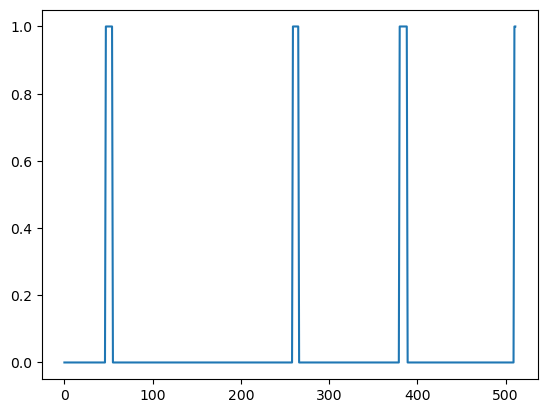

In [59]:
plt.plot(ne[1][:,0])

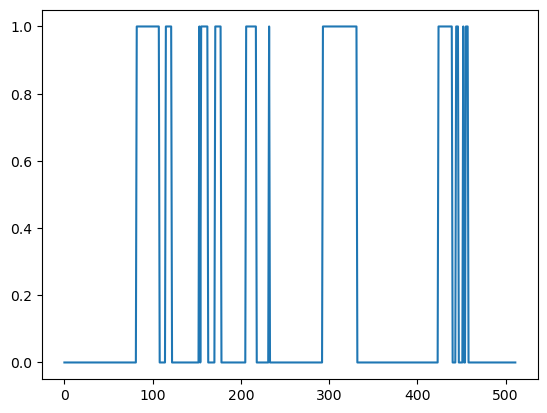

In [60]:
plt.plot(ne[1][:,1])

In [61]:
evl = model.evaluate(tfGenEval)
evl

INFO:root:File 'IE00BLSNMW37.csv' loaded, 277 left
INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


      3/Unknown - 5s 385ms/step - loss: 0.7772

INFO:root:File 'IE00BCRY6003.csv' loaded, 276 left


      9/Unknown - 9s 524ms/step - loss: 0.8007

INFO:root:File 'IE00BMDX0M10.csv' loaded, 275 left


     11/Unknown - 10s 534ms/step - loss: 0.8082

11/11 [==============================] - 10s 562ms/step - loss: 0.8082


0.8082290887832642

In [62]:
p = model.predict(tfGenEval)
p.shape

INFO:root:File 'IE00B1FZS350.csv' loaded, 0 left


      3/Unknown - 4s 379ms/step

INFO:root:File 'DE000ETF7029.csv' loaded, 274 left


      4/Unknown - 5s 421ms/step

INFO:root:File 'IE00BFD2H405.csv' loaded, 273 left


      9/Unknown - 8s 572ms/step

INFO:root:File 'LU1437018598.csv' loaded, 272 left


     11/Unknown - 10s 623ms/step

11/11 [==============================] - 10s 632ms/step


(5632, 3)

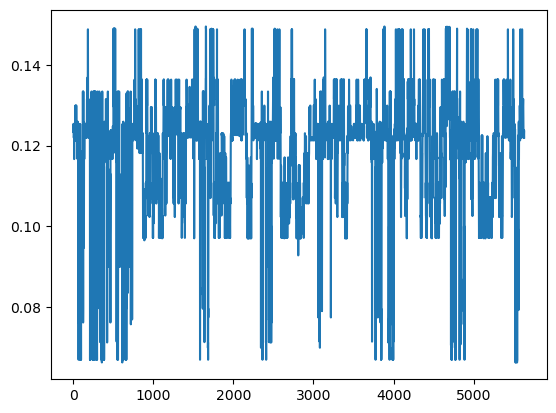

In [63]:
plt.plot(p[:,0])

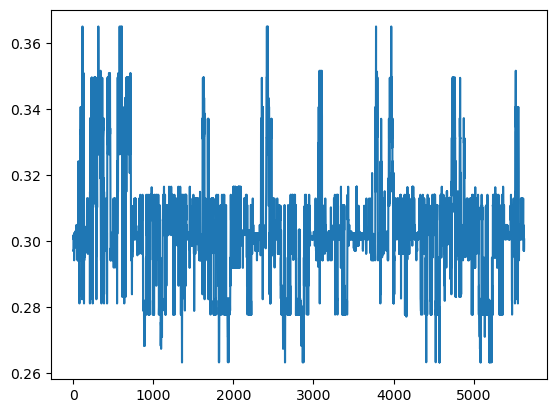

In [64]:
plt.plot(p[:,1])

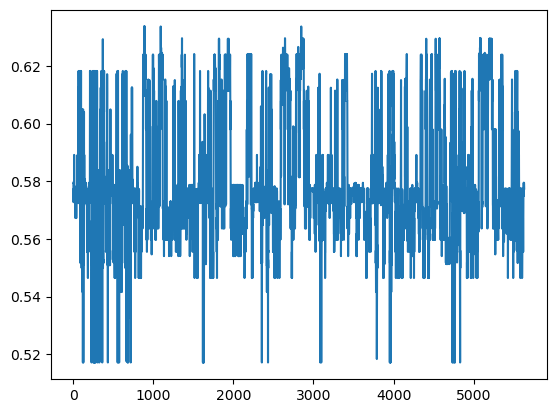

In [65]:
plt.plot(p[:,2])

In [66]:
p.shape

(5632, 3)

In [67]:
tickDF = pd.read_csv(TRAIN_FILES[1])
tickDF

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [68]:
tickDF.shape[0] - p.shape[0]

-311

In [69]:
tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
tickDFcropped

,startsAt,open,high,low,close,volume,quoteVolume
0,1217548800,80.95,80.95,80.95,80.95,0.0,0.0
1,1217635200,80.95,80.95,80.95,80.95,0.0,0.0
2,1217721600,80.95,80.95,80.95,80.95,0.0,0.0
3,1217808000,81.11,81.11,81.11,81.11,0.0,0.0
4,1217894400,81.10,81.10,81.10,81.10,0.0,0.0
...,...,...,...,...,...,...,...
5316,1676851200,140.38,140.38,140.38,140.38,0.0,0.0
5317,1676937600,140.07,140.07,140.07,140.07,0.0,0.0
5318,1677024000,140.11,140.11,140.11,140.11,0.0,0.0
5319,1677110400,140.70,140.70,140.70,140.70,0.0,0.0


In [70]:
# p_dir = p[:,0]
# p_dir_derivation = p[:,1]

p_entry = p[:,0]
p_exit = p[:,1]
p_neutral = p[:,2]

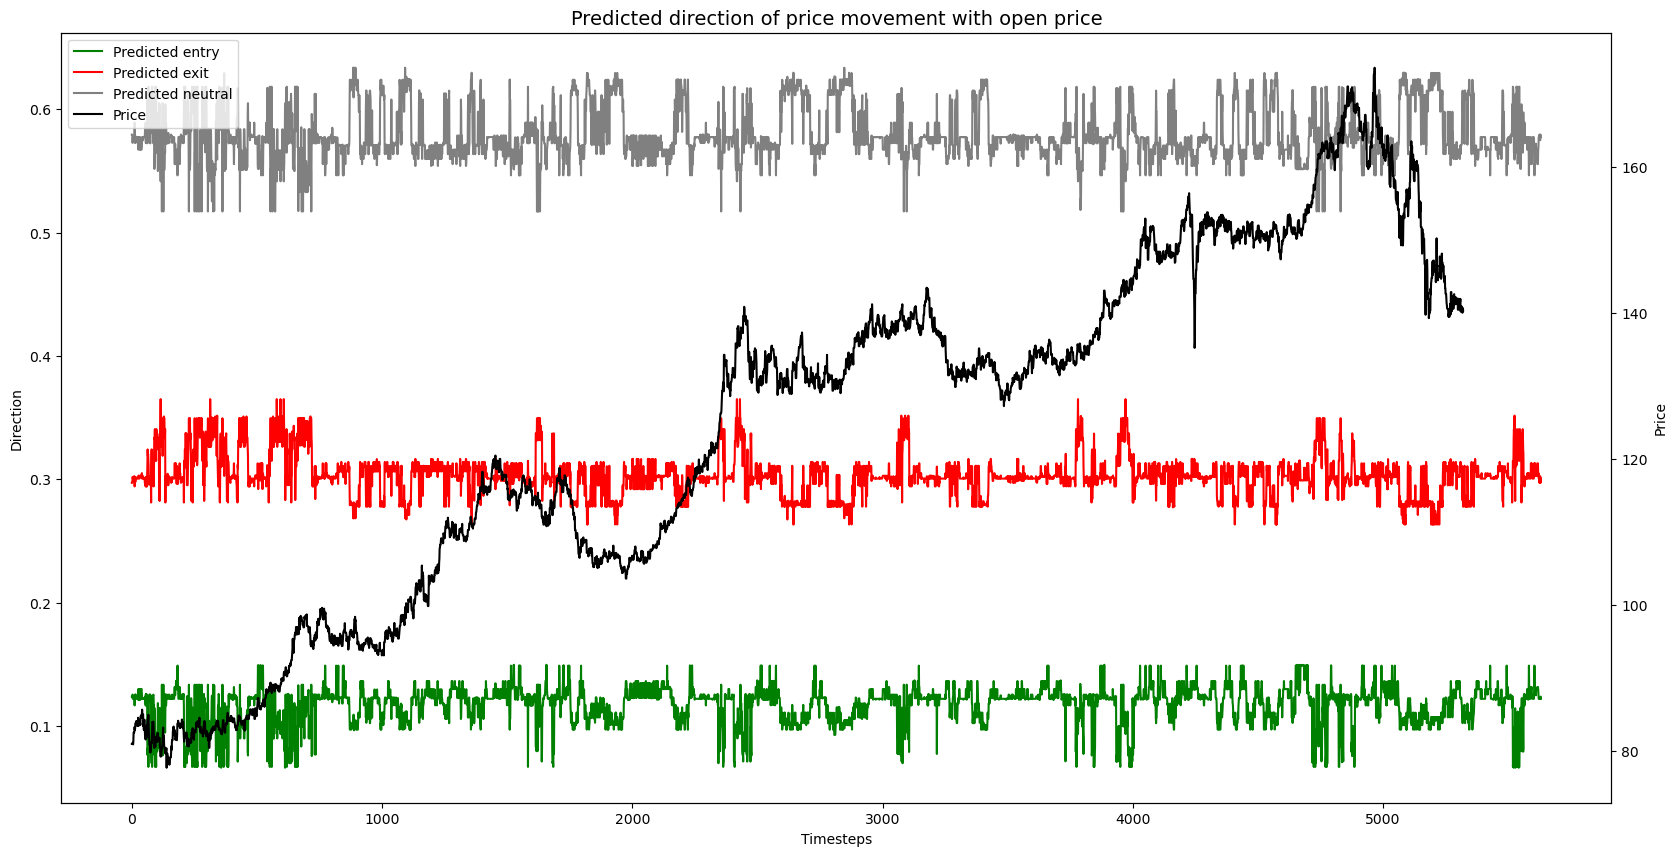

In [71]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_entry, color="green", label="Predicted entry")
_ = ax1.plot(p_exit, color="red", label="Predicted exit")
_ = ax1.plot(p_neutral, color="gray", label="Predicted neutral")

ax2 = ax1.twinx()

ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [72]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

NameError: name 'p_past_gain' is not defined

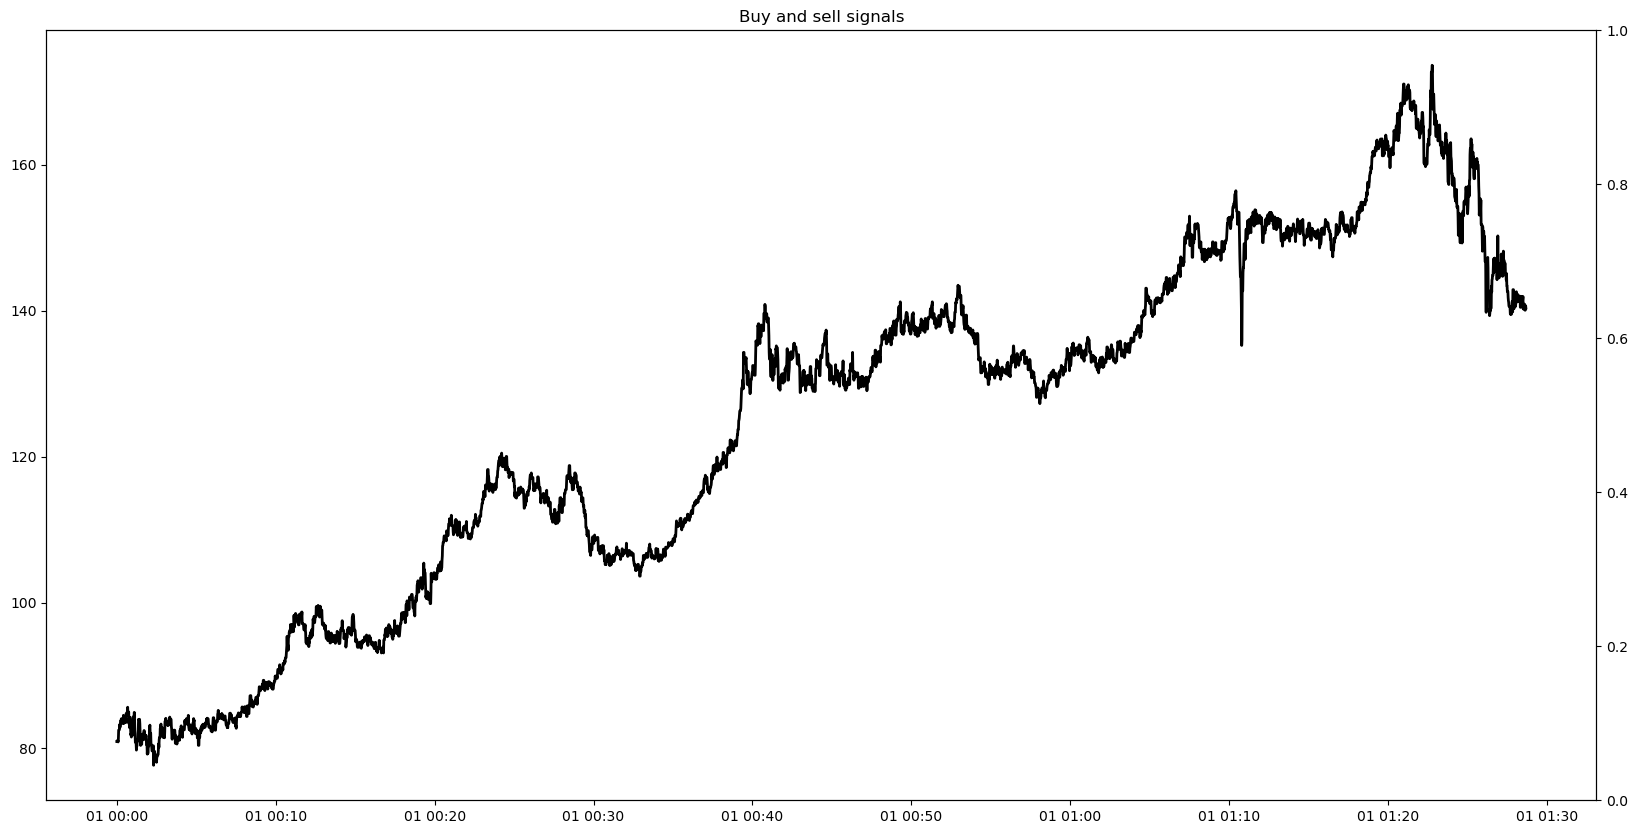

In [73]:
#@title Plot buy and sell signals
chart_name="Buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

_ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_past_gain >= SELL_SIGNAL_THRESHOLD_PAST
yCategoryRise = (p_future_gain > p_past_gain) & (p_past_gain <= BUY_SIGNAL_THRESHOLD_FUTURE) #(p_future_gain >= BUY_SIGNAL_THRESHOLD_FUTURE)

ax2.fill_between(x_datetimes, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes, p_future_gain, color="blue", label="Predicted future gain")
# _ = ax3.plot(x_datetimes, 10.0*p_dir_derivation, color="red", label="10.0 * Predicted price direction derivation")
# ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes), np.max(x_datetimes)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Add predictions to tick tables

In [ ]:
stop

In [ ]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [ ]:
# !mkdir /content/dataset/etffancy/PastFutureSignalsV6
# !mkdir /content/dataset/etffancy/PastFutureSignalsV6/test
# !mkdir /content/dataset/etffancy/PastFutureSignalsV6/eval

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

# fileList = EVAL_FILES
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/eval5"

fileList = TEST_FILES
PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test5"

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                           (BATCH_SIZE, 2)
                                                           )
                                                       )
        p = model.predict(tfGenEval, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_past_gain = p[:,0]
        p_future_gain = p[:,1]

        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]

        tickDFcropped.loc[:,"p_past_gain"] = p_past_gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain

        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

INFO:root:File 'LU0480132876.csv' loaded, 271 left
